**TRIMER with LJ example**

We will simulate the trimer model in vacuum with atoms bounded by the Lennard-Jones potential

$$ U_{LJ}(r) = \frac{1}{r^{12}} - \frac{1}{r^6}$$

for interatomic distance $r>0$

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
from IPython.display import HTML
plt.rcParams["figure.figsize"] = (6,4.5) # adjusts plot dimension parameters
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["font.sans-serif"] = ['Tahoma'] # changes font

In [2]:
def U_LJ(r): 
    u = np.power(r,-12) - np.power(r,-6)
    return u

In [3]:
def derivatives_LJ(q1,q2):
    r = np.linalg.norm( q1-q2 )
    energy = U_LJ(r)
  
    q1x = q1[0] 
    q1y = q1[1]
    q2x = q2[0] 
    q2y = q2[1] 
    
    dU_dr = -12/r**13 + 6/r**7  # [!] 
    
    dnorm_dq1x = (q1x-q2x)/r 
    dnorm_dq1y = (q1y-q2y)/r  # [!]  
    dnorm_dq2x = -(q1x-q2x)/r  # [!] 
    dnorm_dq2y = -(q1y-q2y)/r  # [!] 
    
    dulj_dq1x = dU_dr * dnorm_dq1x
    dulj_dq1y = dU_dr * dnorm_dq1y
    dulj_dq2x = dU_dr * dnorm_dq2x
    dulj_dq2y = dU_dr * dnorm_dq2y
    
    return energy, dulj_dq1x, dulj_dq1y, dulj_dq2x, dulj_dq2y

In [4]:
def force_LJ(q1,q2):
    F1 = np.zeros_like(q1) 
    F2 = np.zeros_like(q2)
    
    energy, du_dq1x, du_dq1y, du_dq2x, du_dq2y = derivatives_LJ(q1,q2)
    
    F1[0] = -du_dq1x
    F1[1] = -du_dq1y
    F2[0] = -du_dq2x
    F2[1] = -du_dq2y
    
    return energy, F1, F2 

In [5]:
def total_force(q):
    q1 = q[0:2]
    q2 = q[2:4]
    q3 = q[4:6]
     
    # Find the derivatives for the three terms
    e12, f12, f21 = force_LJ(q1,q2)
    e13, f13, f31 = force_LJ(q1,q3)
    e23, f23, f32 = force_LJ(q2,q3)
    
    pe = e12 + e13 + e23 
    f1 = f12 + f13 
    f2 = f21 + f23 
    f3 = f31 + f32 

    f = np.hstack([f1, f2, f3]) 
    
    return pe, f 

In [6]:
def Verlet(q,p,h, force_function): # Stormer-Verlet method
    pe, f = force_function(q)
    pt2 = p + h * f/2
    qt = q + h * pt2
    pe, f = force_function(qt)
    pt = pt2 + h * f/2
    
    ke = np.sum( pt*pt) / 2 
    total_e = ke + pe 
    
    return qt, pt, total_e

In [7]:
def STI(q0, p0, h, force_function): # simplified Takahashi-Imada method
    alpha = 1/12
    # p(n+1/2) = pn + h/2 * f(qn + a*h^2*f(qn))
    p1 = p0 + h/2*force_function(q0 + alpha * h**2 * force_function(q0)[1])[1]
    # q(n+1) = qn + h*p(n+1/2)
    qt = q0 + h*p1
    #p(n+1) = p(n+1/2) + h/2 * f(q(n+1) + a*h^2*f(q(n+1)))
    pe,f = force_function(qt)
    pt = p1 + h/2*force_function(qt + alpha * h**2 *f)[1]
    
    ke = np.dot(pt,pt) / 2
    total_e = ke + pe 
    
    return qt, pt, total_e

In [8]:
def hessian_LJ(q1,q2,dq1x,dq1y,dq2x,dq2y): # hessian between two 2D atoms
    r = np.linalg.norm(q1-q2)
    q1x = q1[0] 
    q1y = q1[1]
    q2x = q2[0] 
    q2y = q2[1]
    
    dUr = -12/r**14 + 6/r**8
    main = 12*14/r**15 - 6*8/r**9
    distx = q1x - q2x
    disty = q1y - q2y
    
    h = np.zeros((4,4))
    # diagonal
    h[0,0] = main * distx**2 + dUr #dq1x^2
    h[1,1] = main * disty**2 + dUr #dq1y^2
    h[2,2] = main * distx**2 + dUr #dq2x^2
    h[3,3] = main * disty**2 + dUr #dq2y^2
    # 1st row
    h[0,1] = main * distx * disty #dq1x dq1y
    h[0,2] = -main * distx**2 - dUr #dq1x dq2x
    h[0,3] = -main * distx * disty #dq1x dq2y
    # 2nd row
    h[1,2] = -main * disty * distx #dq1y dq2x
    h[1,3] = -main * disty**2 - dUr #dq1y dq2y
    # 3rd row
    h[2,3] = -main * distx * disty
    # symmetries
    h[1,0] = h[0,1]
    h[2,0] = h[0,2]
    h[3,0] = h[0,3]
    h[2,1] = h[1,2]
    h[3,1] = h[1,3]
    h[3,2] = h[2,3]
    
    return h

In [9]:
def hessian_full(q): # hessian for the trimer
    q1 = np.array(q[0:2])
    q2 = np.array(q[2:4])
    q3 = np.array(q[4:6])

    # since the full LJ potential has 3 components (3 combinations of 2 atoms), we can
    # partition the Hessian into 3 'subhessians' and add them together well
    e, dq1x, dq1y, dq2x, dq2y = derivatives_LJ(q1,q2)
    H12 = hessian_LJ(q1, q2, dq1x, dq1y, dq2x, dq2y)
    e, dq2x, dq2y, dq3x, dq3y = derivatives_LJ(q2,q3)
    H23 = hessian_LJ(q2, q3, dq2x, dq2y, dq3x, dq3y)
    e, dq1x, dq1y, dq3x, dq3y = derivatives_LJ(q1,q3)
    H13 = hessian_LJ(q1, q3, dq1x, dq1y, dq3x, dq3y)
    
    H =  np.zeros((6,6))
    H[0:4,0:4] += H12
    H[2:6,2:6] += H23
    H[0:2,0:2] += H13[0:2,0:2]
    H[4:6,4:6] += H13[2:4,2:4]
    H[0:2,4:6] += H13[0:2,2:4]
    H[4:6,0:2] += H13[2:4,0:2]
    
    return H

In [10]:
def TI(q0, p0, h, force_function): # Takahashi-Imada method
    alpha = 1/12
    
    # p(n+1/2) = pn + h/2 * f(qn + a*h^2*f(qn))
    f0 = force_function(q0)[1]
    H0 = hessian_full(q0)
    p1 = p0 + h/2*(f0 + alpha * h**2 * np.dot(H0,f0))
    
    # q(n+1) = qn + h*p(n+1/2)
    qt = q0 + h*p1
    
    #p(n+1) = p(n+1/2) + h/2 * f(q(n+1) + a*h^2*f(q(n+1)))
    pe, f1 = force_function(qt)
    H1 = hessian_full(qt)
    pt = p1 + h/2*(f1 + alpha * h**2 * np.dot(H0,f0))
    
    ke = np.dot(pt,pt) / 2
    total_e = ke + pe 
    
    return qt, pt, total_e

In [11]:
def Yoshida(q0, p0, h, force_function): # 4th order Yoshida method
    tau0 = 1 / (2 - 2**(1/3))
    tau1 = -2**(1/3) / (2 - 2**(1/3))
    
    q1, p1, _ = Verlet(q0, p0, h*tau0, force_function)
    q2, p2, _ = Verlet(q1, p1, h*tau1, force_function)
    qt, pt, total_e = Verlet(q2, p2, h*tau0, force_function)
    
    return qt, pt, total_e

In [12]:
def run_simulation(q0, p0, Nsteps, h, step_function, force_function):
    # Initialize the output trajectories
    q_traj = [] 
    p_traj = [] 
    e_traj = [] 
    t_traj = []

    # Set initial conditions
    q = np.copy(q0)
    p = np.copy(p0)
    t = 0

    # Main loop
    for n in range(Nsteps):
        
        # Step in time
        q,p,energy = step_function(q, p, h, force_function)
        t = t + h 

        # Save the system's data
        q_traj += [q] 
        p_traj += [p] 
        e_traj += [energy] 
        t_traj += [t] 

    # Format into numpy arrays
    q_traj = np.array(q_traj)
    p_traj = np.array(p_traj) 

    # Return the trajectories
    return q_traj, p_traj, e_traj, t_traj

In [13]:
# initial positions
min_lj = 2 ** (1/6) # 2^(1/6) = the minimiser of the potential energy
q1x = 0
q1y = 0
q2x = min_lj
q2y = 0
q3x = min_lj/2 
q3y = np.sqrt(3)/2*min_lj
q0 = np.array([q1x,q1y,q2x,q2y,q3x,q3y])
p0 = np.random.randn( 6 ) * 0.25 

In [14]:
h = 0.01
T = 25
Nsteps = int(T/h)

q_trajV, p_trajV, e_trajV, t_trajV = run_simulation(q0, p0, Nsteps, h, Verlet, total_force)
q_trajSTI, p_trajSTI, e_trajSTI, t_trajSTI = run_simulation(q0, p0, Nsteps, h, STI, total_force)
q_trajTI, p_trajTI, e_trajTI, t_trajTI = run_simulation(q0, p0, Nsteps, h, TI, total_force)
q_trajY, p_trajY, e_trajY, t_trajY = run_simulation(q0, p0, Nsteps, h, Yoshida, total_force)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


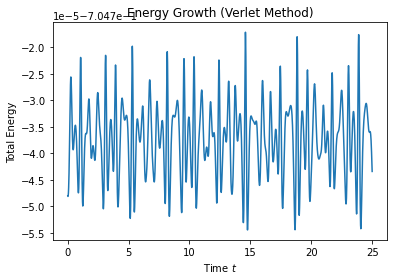

In [15]:
plt.plot(t_trajV, e_trajV, color = 'tab:blue')
plt.xlabel('Time $t$')
plt.ylabel('Total Energy')
plt.title('Energy Growth (Verlet Method)')
plt.savefig('EG-1a.png')
plt.show()

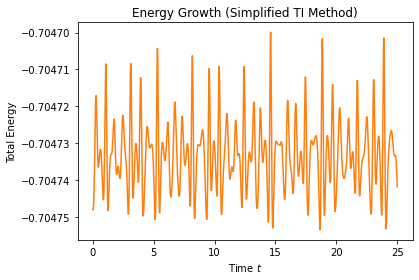

In [16]:
plt.plot(t_trajSTI, e_trajSTI, color = 'tab:orange')
plt.xlabel('Time $t$')
plt.ylabel('Total Energy')
plt.title('Energy Growth (Simplified TI Method)')
plt.savefig('EG-1b.png')
plt.show()

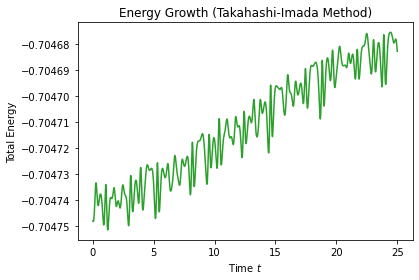

In [17]:
plt.plot(t_trajTI, e_trajTI, color = 'tab:green')
plt.xlabel('Time $t$')
plt.ylabel('Total Energy')
plt.title('Energy Growth (Takahashi-Imada Method)')
plt.savefig('EG-1c.png')
plt.show()

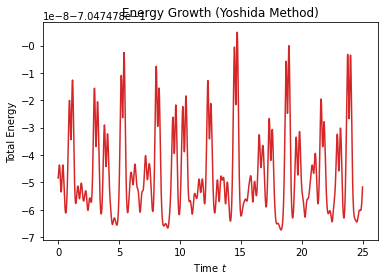

In [18]:
plt.plot(t_trajY, e_trajY, color = 'tab:red')
plt.xlabel('Time $t$')
plt.ylabel('Total Energy')
plt.title('Energy Growth (Yoshida Method)', x = 0.53)
plt.savefig('EG-1d.png')
plt.show()

In [19]:
print('Max. energy error of V:',max([abs(ele) for ele in e_trajV]))
print('Max. energy error of STI:',max([abs(ele) for ele in e_trajSTI]))
print('Max. energy error of TI:',max([abs(ele) for ele in e_trajTI]))
print(total_force(q0)[0])

Max. energy error of V: 0.704754422998078
Max. energy error of STI: 0.7047535122482815
Max. energy error of TI: 0.7047514596944583
-0.7499999999999999


In [20]:
def Find_Traj(h,T,step_function,force_function):

    Nsteps = int(T / h)

    # Make a copy of our initial values so we
    # don't accidently overwrite them 
    q = np.copy(q0)
    p = np.copy(p0)
    t = 0

    # Initialize our saved trajectory to be blank 
    q_traj = [] 
    p_traj = [] 
    t_traj = [] 
    e_traj = [] 

    # Run the loop 
    for n in range(Nsteps):
        t = t + h
        q,p,energy = step_function(q, p, h, force_function)

        q_traj = q_traj + [q] 
        p_traj = p_traj + [p]
        t_traj = t_traj + [t] 
        e_traj = e_traj + [energy] 

    # Make these into numpy arrays
    q_traj = np.array(q_traj)
    p_traj = np.array(p_traj)
    
    return q_traj,p_traj

def total_energy(q,p,force_function):
    pe,f = force_function(q)
    ke =  np.dot(p,p) / 2
    e = pe + ke
    return e
    
def Find_MaxDif(q_traj,p_traj,h,T,force_function):
    '''
    This function takes trajectory arrays, step size and time and returns the maximum energy difference
    of the arrays (a scalar).
    '''
    Nsteps = int(T / h)
    energydifvec = np.zeros(Nsteps)
    
    for i in range(Nsteps):
        energydifvec[i] = abs(total_energy(q0,p0,force_function)-total_energy(q_traj[i],p_traj[i],force_function))
        
    return max(energydifvec)

In [21]:
# momentum random
q0 = np.array([q1x,q1y,q2x,q2y,q3x,q3y])
p0 = np.random.randn( 6 ) * 0.25 
T=10
h = np.arange(0.001,0.1,0.001)
h_len = len(h)
maxvecSE2 = np.zeros(h_len)
maxvecV2 = np.zeros(h_len)
maxvecSTI2 = np.zeros(h_len)
maxvecTI2 = np.zeros(h_len)
maxvecY2 = np.zeros(h_len)

# loop over stepsizes h
for i in range(h_len):
    # saving the trajectory arrays corresponding to a particular step size into new variables
    q_trajV2,p_trajV2 = Find_Traj(h[i],T,Verlet,total_force)
    q_trajSTI2,p_trajSTI2 = Find_Traj(h[i],T,STI,total_force)
    q_trajTI2,p_trajTI2 = Find_Traj(h[i],T,TI,total_force)
    q_trajY2,p_trajY2 = Find_Traj(h[i],T,Yoshida,total_force)
    # saving the maximum value for each h in the vector of max energy differences
    maxvecV2[i] = Find_MaxDif(q_trajV2,p_trajV2,h[i],T,total_force)
    maxvecSTI2[i] = Find_MaxDif(q_trajSTI2,p_trajSTI2,h[i],T,total_force)
    maxvecTI2[i] = Find_MaxDif(q_trajTI2,p_trajTI2,h[i],T,total_force)
    maxvecY2[i] = Find_MaxDif(q_trajY2,p_trajY2,h[i],T,total_force)

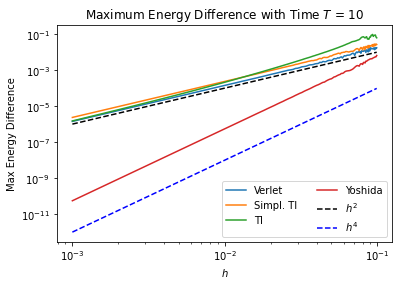

In [22]:
plt.loglog(h,maxvecV2,label="Verlet")
plt.loglog(h,maxvecSTI2,label="Simpl. TI")
plt.loglog(h,maxvecTI2,label="TI")
plt.loglog(h,maxvecY2,label="Yoshida")
plt.loglog(h,h**2,'--k',label="$h^2$")
plt.loglog(h,h**4,'--b',label="$h^4$")

plt.xlabel('$h$')
plt.ylabel('Max Energy Difference') 
plt.title('Maximum Energy Difference with Time $T$ = 10')
plt.legend(ncol = 2)
plt.savefig('trimer_all.png')
plt.show()

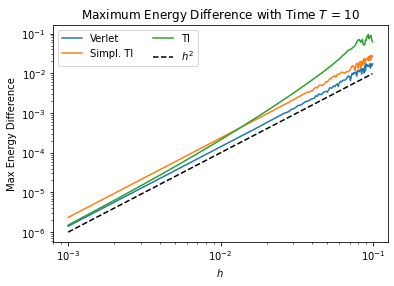

In [23]:
# 2nd order methods only:
plt.loglog(h,maxvecV2,label="Verlet",color="tab:blue")
plt.loglog(h,maxvecSTI2,label="Simpl. TI",color="tab:orange")
plt.loglog(h,maxvecTI2,label="TI",color="tab:green")
plt.loglog(h,h**2,'--k',label="$h^2$")

plt.xlabel('$h$')
plt.ylabel('Max Energy Difference') 
plt.title('Maximum Energy Difference with Time $T$ = 10')
plt.legend(ncol = 2)
plt.savefig('trimer_order2.png')
plt.show()